# Exploration and Evaluation

## Tuning Optimal M Value for Branch and Bound

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load in Data
x_file = 'synthetic_data/batch_1/x_gen_syn_n3_p10_corr0.5_snr5_seed2022_0.csv' 
y_file = 'synthetic_data/batch_1/y_gen_syn_n3_p10_corr0.5_snr5_seed2022_0.csv'
x = np.loadtxt(x_file, delimiter=",")
y = np.loadtxt(y_file, delimiter=",")
l0 = 0.01
l2 = 0

# Fit a linear regression model to estimate coefficients (betas)
linear_model = LinearRegression()
linear_model.fit(x, y)

# Calculate the maximum absolute coefficient value
max_abs_beta = np.max(np.abs(linear_model.coef_))

# Calculate the optimal M value as 1.5 times the maximum absolute coefficient value
optimal_M = 1.5 * max_abs_beta

print(f"Optimal M: {optimal_M}")

Optimal M: 1.342228603310831


## Algorithms

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

### Rough Visualization of Tree Structure

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5):
    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    return pos

def _hierarchy_pos(G, root, width=2., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5, pos = None, parent = None, parsed = []):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    
    children = list(G.neighbors(root))
    if not isinstance(G, nx.DiGraph) and parent is not None:
        children.remove(parent)  
            
    if len(children) != 0:
        dx = width / len(children) 
        nextx = xcenter - width/2 - dx/2
        for child in children:
            nextx += dx
            pos = _hierarchy_pos(G, child, width = dx, vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, parent=root, parsed=parsed)
    
    return pos

def visualize_tree(root):
    if not root:
        return

    tree_graph = nx.DiGraph()

    def add_nodes_edges(node):
        if node.left:
            tree_graph.add_edge(node.node_key, node.left.node_key)
            add_nodes_edges(node.left)
        if node.right:
            tree_graph.add_edge(node.node_key, node.right.node_key)
            add_nodes_edges(node.right)

    add_nodes_edges(root)

    pos = hierarchy_pos(tree_graph, root.node_key)
    nx.draw(tree_graph, pos=pos, with_labels=True, node_size=100, node_color="skyblue", font_size=6, font_weight='bold')
    plt.title("Binary Tree Visualization")
    plt.show()

In [2]:
## Branch and Bound ##
import Tree

p = Tree.Problem(x,y,l0,l2, m = 1.34)
t = Tree.tree(p)
i, nnz, opt_gap = t.branch_and_bound('max')

print(f'Number of iterations: {i}')
print(f'Number of Non-Zero: {nnz}')
print(f'Optimality Gap: {opt_gap}')

Number of iterations: 113
Number of Non-Zero: 1
Optimality Gap: 0.0


In [3]:
## Reinforcement Learning ##

# initialize agent
from Model import Agent
agent = Agent(34)

# agent.epsilon = 0.05

# Solve Using RL Agent
iters, tot_reward, nnz, opt_gap = agent.RL_solve(x,y,l0,l2, m = 1.34, training=True)

print(f'Iterations This Episode: {iters}')
print(f'Total Reward this Episode: {tot_reward}')
print(f'Number of Non-Zero: {nnz}')
print(f'Optimality Gap: {opt_gap}')
print(f'Number of Items in Memory: {len(agent.memory.memory)}')
print("-----------------------------------------")
print(f'Episodes Played: {agent.episodes_played}')
print(f'Epsilon: {round(agent.epsilon,4)}')

Iterations This Episode: 113
Total Reward this Episode: -73
Number of Non-Zero: 1
Optimality Gap: 0.0
Number of Items in Memory: 226
-----------------------------------------
Episodes Played: 1
Epsilon: 0.9774


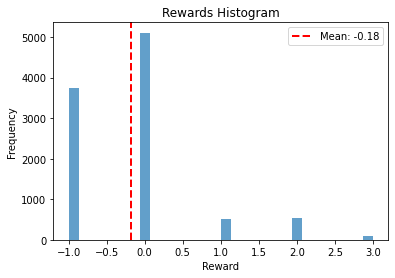

In [219]:
import matplotlib.pyplot as plt

rewards = []

for transition in agent.memory.memory:        
        rewards.append(transition[2].item())

# Step 4: Analyze the Reward Distribution
# Calculating the mean reward for each state pair
mean_rewards = np.mean(rewards)

# Plotting the histogram
plt.hist(rewards, bins=30, alpha=0.7)
plt.axvline(mean_rewards, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_rewards:.2f}")
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title("Rewards Histogram")
plt.legend()
plt.show()

## Testing Algorithms on Synthetic Data

In [1]:
import Model
import os
import numpy as np
import pandas as pd
from random import shuffle
import Tree
import torch
import random

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

DATA_BATCH = 1

# Directory of problems
my_path = "synthetic_data/batch_"+str(DATA_BATCH)
files = [f for f in os.listdir(my_path) if os.path.isfile(os.path.join(my_path,f)) and f[0]=="x"]
shuffle(files)
num_files = 0

# Results
column_names = ["data", "num_file", "L0", "L2", "Epsilon", 
                "RL_iters", "RL_rewards", "RL_nnz", "RL_OG",
                "MF_iters", "MF_nnz", "MF_OG"]
res = pd.DataFrame(columns = column_names)

# Agent RL
agent = Model.Agent()

for f in files:
    print(num_files, flush=True)
    x_file = os.path.join(my_path, f)
    y_file = os.path.join(my_path, "y"+f[1:len(f)])
    x = np.loadtxt(x_file, delimiter = ",")
    y = np.loadtxt(y_file, delimiter=",")
    l0_max = max(abs(np.dot(x.T, y)))/2.0
    l0 = 0.01
    l2 = 0.0

    m = 1.34
    
    # Solve with agent and branch and bound directly
    RL_iters, RL_rewards, RL_nnz, RL_og = agent.RL_solve(x,y,l0,l2, m)

    p = Tree.Problem(x,y,l0,l2, m)
    tree = Tree.tree(p)
    MF_iters, MF_nnz, MF_og = tree.branch_and_bound("max")

    # Add results to file
    data = [[f, num_files, l0, l2, agent.epsilon,
            RL_iters, RL_rewards, RL_nnz, RL_og,
            MF_iters, MF_nnz, MF_og]]
    new_row = pd.DataFrame(data=data, columns=column_names)
    res = pd.concat([res, new_row], ignore_index=True)
    num_files += 1

res

0


,data,num_file,L0,L2,Epsilon,RL_iters,RL_rewards,RL_nnz,RL_OG,MF_iters,MF_nnz,MF_OG
0,x_gen_syn_n3_p10_corr0.5_snr5_seed2022_0.csv,0,0.01,0.0,0.977408,72,-46,1,0.0,72,1,0.0


## Offline Learning

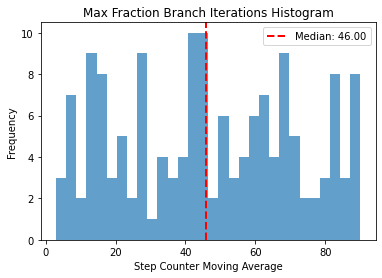

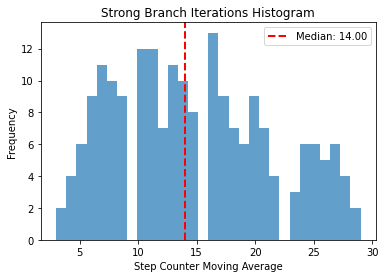

In [3]:
import pickle
import matplotlib.pyplot as plt

# Load max_frac_trees
with open('synthetic_data/trees/max_frac_trees.pkl', 'rb') as f:
    max_frac_trees = pickle.load(f)

# Load strong_branch_trees
with open('synthetic_data/trees/strong_branch_trees.pkl', 'rb') as f:
    strong_branch_trees = pickle.load(f)

def plot_histogram(trees, title):
    step_counters = [tree.step_counter for tree in trees]

    med = np.median(step_counters)

    # Plotting the histogram
    plt.hist(step_counters, bins=30, alpha=0.7)
    plt.axvline(med, color='r', linestyle='dashed', linewidth=2, label=f"Median: {med:.2f}")
    plt.xlabel('Step Counter Moving Average')
    plt.ylabel('Frequency')
    plt.title(f"{title} Iterations Histogram")
    plt.legend()
    plt.show()

# Plot moving averages for both sets of trees
plot_histogram(max_frac_trees, "Max Fraction Branch")
plot_histogram(strong_branch_trees, "Strong Branch")

In [11]:
MF_threshold = 90 
SB_threshold = 30 

max_frac_trees_filtered = [tree for tree in max_frac_trees if tree.step_counter <= MF_threshold]
strong_branch_trees_filtered = [tree for tree in strong_branch_trees if tree.step_counter <= SB_threshold]

In [15]:
print(len(max_frac_trees_filtered), len(strong_branch_trees_filtered))

405 293


In [13]:
# Save filtered max_frac_trees
with open('synthetic_data/trees/max_frac_trees.pkl', 'wb') as f:
    pickle.dump(max_frac_trees_filtered, f)

# Save filtered strong_branch_trees
with open('synthetic_data/trees/strong_branch_trees.pkl', 'wb') as f:
    pickle.dump(strong_branch_trees_filtered, f)

## Evaluating Results

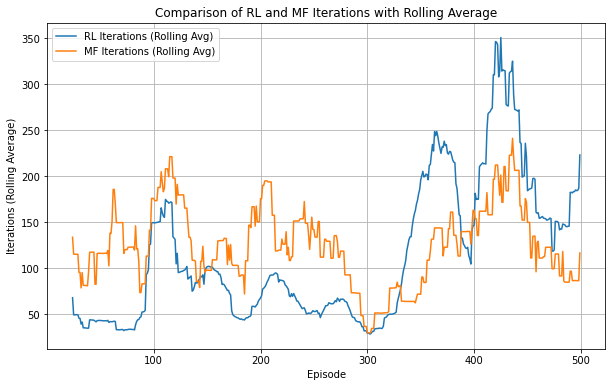

In [275]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Results CSV file
file_path = 'synthetic_data/results/results17.csv' 
df = pd.read_csv(file_path)

# Rolling averages
rolling_window_size = 25  # Adjust
df['RL_iters_rolling'] = df['RL_iters'].rolling(window=rolling_window_size).mean()
df['MF_iters_rolling'] = df['MF_iters'].rolling(window=rolling_window_size).mean()
# df['SB_iters_rolling'] = df['SB_iters'].rolling(window=rolling_window_size).mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['RL_iters_rolling'], label='RL Iterations (Rolling Avg)')
plt.plot(df['MF_iters_rolling'], label='MF Iterations (Rolling Avg)')
# plt.plot(df['SB_iters_rolling'], label='SB Iterations (Rolling Avg)')
plt.xlabel('Episode')
plt.ylabel('Iterations (Rolling Average)')
plt.title('Comparison of RL and MF Iterations with Rolling Average')
plt.legend()
plt.grid(True)
plt.show()

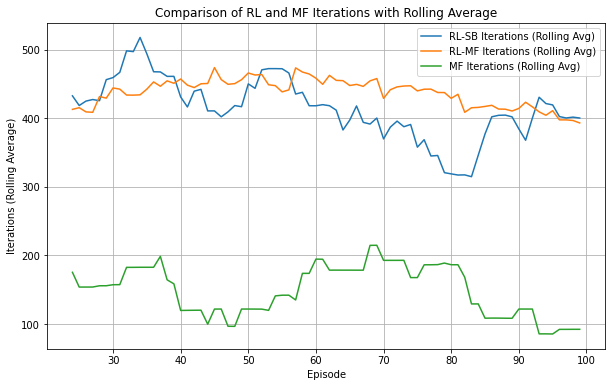

In [237]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the Results CSV file
file_path = 'synthetic_data/results/results14.csv' 
df = pd.read_csv(file_path)

# Rolling averages
rolling_window_size = 25  # Adjust
df['RL-SB_iters_rolling'] = df['RL-SB_iters'].rolling(window=rolling_window_size).mean()
df['RL-MX_iters_rolling'] = df['RL-MX_iters'].rolling(window=rolling_window_size).mean()
df['MF_iters_rolling'] = df['MF_iters'].rolling(window=rolling_window_size).mean()

# Step 3: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['RL-SB_iters_rolling'], label='RL-SB Iterations (Rolling Avg)')
plt.plot(df['RL-MX_iters_rolling'], label='RL-MF Iterations (Rolling Avg)')
plt.plot(df['MF_iters_rolling'], label='MF Iterations (Rolling Avg)')
plt.xlabel('Episode')
plt.ylabel('Iterations (Rolling Average)')
plt.title('Comparison of RL and MF Iterations with Rolling Average')
plt.legend()
plt.grid(True)
plt.show()